In [1]:
import os
import argparse
import re
import pandas as pd
from src.util import clean_depts, count_vec
from src.cleaning_regex import deptdic
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.calibration import CalibratedClassifierCV
from scipy.sparse import hstack

import glob
import numpy as np

import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_auc_score
import seaborn as sns

## Data loading and prep

In [2]:
path = f"C:/Users/hwallace/dept_model/MLmodelCutOffScores/Departments"

In [3]:
all_files = glob.glob(os.path.join(path, '[0-9]*_labels.xlsx'))

In [4]:
all_files

['C:/Users/hwallace/dept_model/MLmodelCutOffScores/Departments\\1166_labels.xlsx',
 'C:/Users/hwallace/dept_model/MLmodelCutOffScores/Departments\\1274_labels.xlsx',
 'C:/Users/hwallace/dept_model/MLmodelCutOffScores/Departments\\1282_labels.xlsx',
 'C:/Users/hwallace/dept_model/MLmodelCutOffScores/Departments\\1430_labels.xlsx',
 'C:/Users/hwallace/dept_model/MLmodelCutOffScores/Departments\\3119_labels.xlsx',
 'C:/Users/hwallace/dept_model/MLmodelCutOffScores/Departments\\3235_labels.xlsx',
 'C:/Users/hwallace/dept_model/MLmodelCutOffScores/Departments\\3281_labels.xlsx']

In [5]:
new_clients = pd.concat((pd.read_excel(f, engine="openpyxl") for f in all_files), ignore_index=True)

### Org 1274 had a unnamed column, fixing that

In [6]:
new_clients.groupby(['OrgPin','Unnamed: 12']).size()

OrgPin  Unnamed: 12           
1274    Administration             2
        Administrative             1
        Advanced Imaging           1
        Behavioral                 1
        Care Management            1
        Clinical Laboratory        1
        Clinics                   43
        Emergency                  5
        Fictitious                 6
        Finance                    1
        Information Technology     4
        Medical Education          2
        Oncology                   4
        Patient Care Unit          1
        Rehab/Therapy              1
        Specialty Labs             2
        Surgical Services          7
        Talent/HR                  2
dtype: int64

In [7]:
new_clients.groupby('corrected').size()

corrected
Administration                         193
Advanced Imaging                        23
Behavioral                              11
Care Management                        103
Clinical Laboratory                     20
Clinics                                349
Critical and Intensive Care             25
Dietary Services                         9
Emergency                               57
Environmental Services                  19
Facilities                              43
Fictitious                             288
Finance                                 25
Hospitalists                            28
Information Technology                  18
Medical Education                       54
Non-Operating Revenue                   45
Nursing Administration                  20
Obstetrics                              30
Oncology                                27
Patient Care Unit                      153
Patient Support                         36
Pharmacy                                 2
P

In [8]:
new_clients[new_clients['OrgPin']==1274].groupby(['corrected','Unnamed: 12']).size()

Series([], dtype: int64)

In [9]:
new_clients.corrected = new_clients.corrected.fillna(new_clients['Unnamed: 12'])

In [10]:
new_clients.groupby('corrected').size()

corrected
Administration                         195
Administrative                           1
Advanced Imaging                        24
Behavioral                              12
Care Management                        104
Clinical Laboratory                     21
Clinics                                392
Critical and Intensive Care             25
Dietary Services                         9
Emergency                               62
Environmental Services                  19
Facilities                              43
Fictitious                             294
Finance                                 26
Hospitalists                            28
Information Technology                  22
Medical Education                       56
Non-Operating Revenue                   45
Nursing Administration                  20
Obstetrics                              30
Oncology                                31
Patient Care Unit                      154
Patient Support                         36
P

### One instance of 'Administarative' being corrected to 'Administration'

In [11]:
new_clients.loc[new_clients['corrected']=='Administrative', 'corrected'] = 'Administration'

In [12]:
new_clients.groupby('corrected').size()

corrected
Administration                         196
Advanced Imaging                        24
Behavioral                              12
Care Management                        104
Clinical Laboratory                     21
Clinics                                392
Critical and Intensive Care             25
Dietary Services                         9
Emergency                               62
Environmental Services                  19
Facilities                              43
Fictitious                             294
Finance                                 26
Hospitalists                            28
Information Technology                  22
Medical Education                       56
Non-Operating Revenue                   45
Nursing Administration                  20
Obstetrics                              30
Oncology                                31
Patient Care Unit                      154
Patient Support                         36
Pharmacy                                 2
P

In [13]:
new_clients = new_clients.drop('Unnamed: 12', axis=1)

In [14]:
new_clients.groupby('OrgPin').size()

OrgPin
1166    6009
1274    1763
1282    1150
1430    2241
3119     276
3235     494
3281     237
dtype: int64

### If the column named 'corrected' is null, the prediction was correct, and we set the column 'label' = 1, else 'label' = 0

In [15]:
new_clients['label'] = 0
new_clients.loc[new_clients.corrected.isnull(), 'label'] = 1
new_clients['confidence'] = new_clients['confidence']/100

In [16]:
new_clients.head(30)

,OrgPin,Client,DepartmentCode,Description,DepartmentType,Size,Employees,dx_count,TotalIncludedDollars,confidence,label_pred,corrected,label
0,1166,CHRISTUS Health,I303.11101.1105,Mother Frances Hospital Tyler - ICU Cardiovasc...,Revenue,11,x 11,0,0.00,0.903332,Critical and Intensive Care,NaN,1
1,1166,CHRISTUS Health,I303.11101.1113,Mother Frances Hospital Tyler - ICU Neonatal,Revenue,193,x 193,36146,7889612.49,0.975925,Critical and Intensive Care,NaN,1
2,1166,CHRISTUS Health,I303.11101.1116,Mother Frances Hospital Tyler - ICU Neurology,Revenue,236,x 236,17472,9171658.67,0.997393,Critical and Intensive Care,NaN,1
3,1166,CHRISTUS Health,I303.11101.1145,Mother Frances Hospital Tyler - ICU Psych Pedi...,Revenue,0,0,0,0.00,0.766292,Behavioral,NaN,1
4,1166,CHRISTUS Health,I303.11101.1175,Mother Frances Hospital Tyler - ICU MedSurgical A,Revenue,243,x 243,20799,12002183.22,0.992764,Critical and Intensive Care,NaN,1
5,1166,CHRISTUS Health,I303.11101.1176,Mother Frances Hospital Tyler - ICU MedSurgical B,Revenue,41,x 41,3453,1163145.84,0.976164,Critical and Intensive Care,NaN,1
6,1166,CHRISTUS Health,I303.11101.1177,Mother Frances Hospital Tyler - ICU MedSurgical C,Revenue,60,x 60,1878,0.00,0.984126,Critical and Intensive Care,NaN,1
7,1166,CHRISTUS Health,I303.11101.1190,Mother Frances Hospital Tyler - ICU General,Revenue,3,x 3,0,0.00,0.694033,Critical and Intensive Care,NaN,1
8,1166,CHRISTUS Health,I303.11101.1204,Mother Frances Hospital Tyler - Acute Cardiac,Revenue,13,x 13,0,0.00,0.424134,Clinics,Patient Care Unit,0
9,1166,CHRISTUS Health,I303.11101.1205,Mother Frances Hospital Tyler - Acute Cardiova...,Revenue,12,x 12,0,0.00,0.742409,Clinics,Patient Care Unit,0


## Analysis Begins

### Confidence scores are overconfident, but do a pretty good job of monotonically seperating low confidence from high confidence

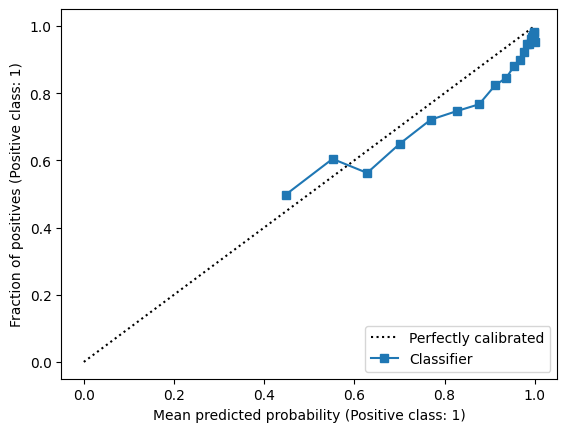

In [17]:
disp = CalibrationDisplay.from_predictions(new_clients['label'], new_clients['confidence'], n_bins=20, strategy='quantile')

In [18]:
disp.__dict__

{'prob_true': array([0.49753695, 0.60426929, 0.5625    , 0.64967105, 0.72085386,
        0.74671053, 0.76683087, 0.82401316, 0.8456486 , 0.88157895,
        0.89967105, 0.9228243 , 0.94736842, 0.94745484, 0.96217105,
        0.96715928, 0.97368421, 0.9819376 , 0.97861842, 0.95238095]),
 'prob_pred': array([0.44750087, 0.55157244, 0.62832291, 0.70096514, 0.76914543,
        0.82762776, 0.87664023, 0.91265304, 0.93704945, 0.9546157 ,
        0.966539  , 0.975222  , 0.98191136, 0.9870946 , 0.99110312,
        0.99391009, 0.99611102, 0.99769554, 0.99875552, 0.99957864]),
 'y_prob': 0        0.903332
 1        0.975925
 2        0.997393
 3        0.766292
 4        0.992764
            ...   
 12165    0.999684
 12166    0.979657
 12167    0.814360
 12168    0.914628
 12169    0.514357
 Name: confidence, Length: 12170, dtype: float64,
 'estimator_name': 'Classifier',
 'pos_label': 1,
 'line_': <matplotlib.lines.Line2D at 0x2a237961fa0>,
 'ax_': <AxesSubplot:xlabel='Mean predicted probabili

In [19]:
new_clients['row_cnt'] = 1

In [20]:
# def get_sd(df):
#     if np.mean(df['label']) == 1:
#         return 1
#     return roc_auc_score(df['label'], df['confidence'])*2-1

In [21]:
# for pred in new_clients.label_pred.unique():
#     df = new_clients[new_clients.label_pred==pred]
#     print(pred, df.shape, get_sd(df), np.mean(df.confidence), np.mean(df.label))
#     print(np.mean(df.label) - np.mean(df.confidence))

#### List of labels ordered by how overconfident or underconfident their confidence scores are. 
Negative scores are overconfident (meaning we should always manually review them), positive scores are underconfident

I would suggest ALWAYS manually reviewing predictions, no matter the confidence scores, for:
* Facilities

Depending on comfort, might be good to always manual review looking predictions for:
* Surgical Services 
* Post-Acute Care and Hospice
* Talent/HR
* Patient Care Unit

In [ ]:
['Facilities', 'Surgical Services', 'Post-Acute Care and Hospice', 'Talent/HR', 'Patient Care Unit']

In [22]:
by_label = new_clients.groupby('label_pred').agg({'row_cnt': 'sum', 'confidence': 'mean', 'label': 'mean'})
by_label['difference'] = by_label['label'] - by_label['confidence']
by_label = by_label.rename(columns={'confidence':'mean_confidence_score','label':'proportion_correct'})
by_label.sort_values(by=['difference'])

,row_cnt,mean_confidence_score,proportion_correct,difference
label_pred,,,,
Facilities,1056,0.811716,0.538826,-0.272890
Surgical Services,656,0.915398,0.757622,-0.157776
Post-Acute Care and Hospice,73,0.896159,0.739726,-0.156433
Talent/HR,116,0.868054,0.724138,-0.143916
Patient Care Unit,511,0.862288,0.727984,-0.134304
Specialty Labs,377,0.908804,0.838196,-0.070608
Administration,776,0.844570,0.782216,-0.062354
Clinics,3157,0.880288,0.821983,-0.058305
Transplant,44,0.850114,0.818182,-0.031932


In [23]:
# for org in new_clients.OrgPin.unique():
#     df = new_clients[new_clients.OrgPin==org]
#     print(org, df.shape, get_sd(df), np.mean(df.confidence), np.mean(df.label))

### List of orgs ordered by how overconfident or underconfident their confidence scores are. 

While there are some differences, nothing concerns me here.

In [24]:
by_label = new_clients.groupby('OrgPin').agg({'row_cnt': 'sum', 'confidence': 'mean', 'label': 'mean'})
by_label['difference'] = by_label['label'] - by_label['confidence']
by_label = by_label.rename(columns={'confidence':'mean_confidence_score','label':'proportion_correct'})
by_label.sort_values(by=['difference'])

,row_cnt,mean_confidence_score,proportion_correct,difference
OrgPin,,,,
1274,1763,0.859469,0.798639,-0.060830
1166,6009,0.850010,0.791479,-0.058531
3281,237,0.950163,0.898734,-0.051429
1430,2241,0.929769,0.908969,-0.020800
3119,276,0.956148,0.942029,-0.014119
1282,1150,0.885154,0.873913,-0.011241
3235,494,0.873105,0.894737,0.021632


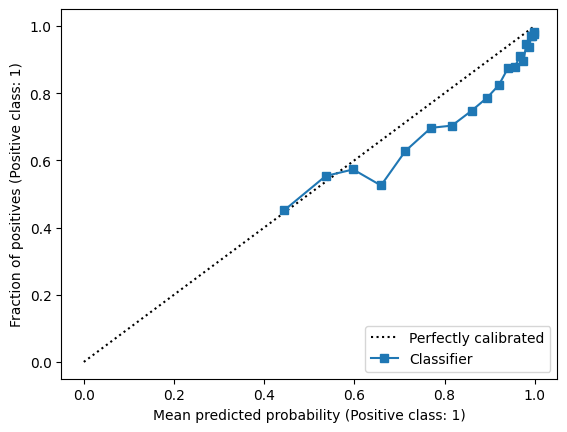

In [25]:
client1430 = new_clients[new_clients.OrgPin==1166]
disp = CalibrationDisplay.from_predictions(client1430['label'], client1430['confidence'], n_bins=20, strategy='quantile')

In [26]:
disp.__dict__

{'prob_true': array([0.45182724, 0.55333333, 0.57284768, 0.52508361, 0.62790698,
        0.69666667, 0.70333333, 0.74750831, 0.78666667, 0.82392027,
        0.87333333, 0.87666667, 0.91089109, 0.89597315, 0.94684385,
        0.93666667, 0.97      , 0.97009967, 0.98333333, 0.97674419]),
 'prob_pred': array([0.44484962, 0.53634083, 0.59731741, 0.65903081, 0.7132387 ,
        0.76998747, 0.8164161 , 0.85990757, 0.8946321 , 0.92035427,
        0.94026034, 0.95592832, 0.96667746, 0.97497197, 0.98162632,
        0.98696698, 0.9914377 , 0.99492342, 0.99733813, 0.99883793]),
 'y_prob': 0       0.903332
 1       0.975925
 2       0.997393
 3       0.766292
 4       0.992764
           ...   
 6004    0.990698
 6005    0.998360
 6006    0.630411
 6007    0.967204
 6008    0.993023
 Name: confidence, Length: 6009, dtype: float64,
 'estimator_name': 'Classifier',
 'pos_label': 1,
 'line_': <matplotlib.lines.Line2D at 0x2a22bae10a0>,
 'ax_': <AxesSubplot:xlabel='Mean predicted probability (Positive

<AxesSubplot:xlabel='confidence', ylabel='Count'>

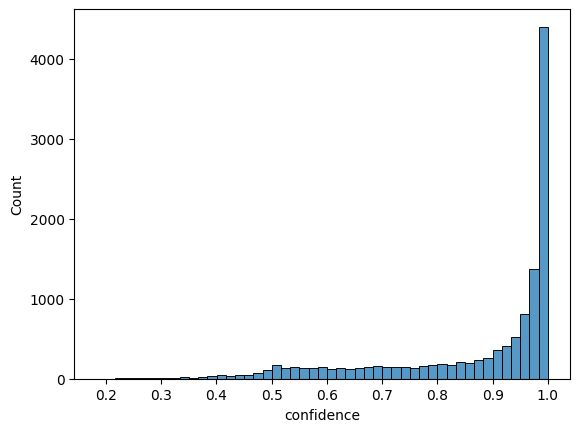

In [27]:
sns.histplot(new_clients['confidence'])

### Creating more 'human' confidence score buckets rather quantiles

In [28]:
cutoffs = ([0] + 
           list(np.linspace(.5,.9, 9)) + 
           [.92, .94, .96, .97, .98, .985, .99, .9925, .995, .9975, 1]
          )

In [29]:
new_clients['confidence_score_bucket'] = pd.cut(new_clients['confidence'], cutoffs)

In [30]:
new_clients.groupby('confidence_score_bucket').size()

confidence_score_bucket
(0.0, 0.5]         463
(0.5, 0.55]        440
(0.55, 0.6]        409
(0.6, 0.65]        376
(0.65, 0.7]        437
(0.7, 0.75]        448
(0.75, 0.8]        474
(0.8, 0.85]        558
(0.85, 0.9]        696
(0.9, 0.92]        425
(0.92, 0.94]       536
(0.94, 0.96]       776
(0.96, 0.97]       544
(0.97, 0.98]       829
(0.98, 0.985]      533
(0.985, 0.99]      683
(0.99, 0.992]      477
(0.992, 0.995]     611
(0.995, 0.998]     840
(0.998, 1.0]      1615
dtype: int64

### Mean confidence scores and the percent of the observations in each bucket that are correct

In [31]:
new_clients.groupby('confidence_score_bucket')[['confidence','label']].mean().rename(columns={'confidence':'mean_confidence_score','label':'proportion_correct'})

,mean_confidence_score,proportion_correct
confidence_score_bucket,,
"(0.0, 0.5]",0.428987,0.490281
"(0.5, 0.55]",0.523581,0.568182
"(0.55, 0.6]",0.575432,0.611247
"(0.6, 0.65]",0.625355,0.555851
"(0.65, 0.7]",0.675974,0.597254
"(0.7, 0.75]",0.725581,0.700893
"(0.75, 0.8]",0.777023,0.715190
"(0.8, 0.85]",0.825840,0.738351
"(0.85, 0.9]",0.876307,0.772989


### Looking at the mean confidence scores and proportion correct cumulatively, from the highest confidence down to the lowest confidence
I think this is the most important view to make a decision. 

For example, it shows us that if you were to manually verify everything under .9 confidence score, and ignore everything above .9, 
you would reduce the work by ~65%, and expect about ~7% of the unverified observations to be incorrect.

While there is no objectively correct answer, this is probably the cut I would make.

This does not take into account the labels that are overconfident shown earlier in the analysis.

In [51]:
bucket_cumavg = new_clients.groupby('confidence_score_bucket')[['confidence','label','row_cnt']].sum().sort_index(ascending=False).cumsum().reset_index()
bucket_cumavg['mean_confidence_score'] = bucket_cumavg['confidence']/bucket_cumavg['row_cnt']
bucket_cumavg['proportion_correct'] = bucket_cumavg['label']/bucket_cumavg['row_cnt']
bucket_cumavg['total'] = len(new_clients)
bucket_cumavg['row_pct_of_total'] = bucket_cumavg['row_cnt']/bucket_cumavg['total']

In [52]:
bucket_cumavg[['confidence_score_bucket', 'row_cnt','mean_confidence_score', 'proportion_correct', 'row_pct_of_total']]

,confidence_score_bucket,row_cnt,mean_confidence_score,proportion_correct,row_pct_of_total
0,"(0.998, 1.0]",1615,0.998862,0.968421,0.132703
1,"(0.995, 0.998]",2455,0.998010,0.971894,0.201726
2,"(0.992, 0.995]",3066,0.997175,0.969993,0.251931
3,"(0.99, 0.992]",3543,0.996392,0.969235,0.291126
4,"(0.985, 0.99]",4226,0.994973,0.966635,0.347247
5,"(0.98, 0.985]",4759,0.993586,0.964278,0.391044
6,"(0.97, 0.98]",5588,0.990855,0.958304,0.459162
7,"(0.96, 0.97]",6132,0.988577,0.952218,0.503862
8,"(0.94, 0.96]",6908,0.984383,0.944412,0.567625
9,"(0.92, 0.94]",7444,0.980513,0.936862,0.611668


### Repeating the same cumulative analysis, but gaming out how it changes if you ALWAYS manually review either
* Facilities

which is by far the most overconfident prediction label by ~27%

OR

* ['Facilities', 'Surgical Services', 'Post-Acute Care and Hospice', 'Talent/HR', 'Patient Care Unit']

which is all prediction labels that are overconfident by 13%+

In [38]:
## make column to mark if the prediction was facilities
new_clients['facilities'] = 0
new_clients.loc[new_clients.label_pred == 'Facilities', 'facilities'] = 1

## make column to mark if the prediction was  in ['Facilities', 'Surgical Services', 'Post-Acute Care and Hospice', 'Talent/HR', 'Patient Care Unit']
new_clients['facilities_plus'] = 0
cols = ['Facilities', 'Surgical Services', 'Post-Acute Care and Hospice', 'Talent/HR', 'Patient Care Unit']
new_clients.loc[new_clients.label_pred.isin(cols), 'facilities_plus'] = 1

In [47]:
## set all predictions that were facilities to the lowest confidence bucket
new_clients['confidence_facilities'] = new_clients['confidence_score_bucket']
new_clients.loc[new_clients['facilities']==1, 'confidence_facilities'] = pd.Interval(0.0, .5, closed='right')

In [53]:
bucket_cumavg = new_clients.groupby('confidence_facilities')[['confidence','label','row_cnt']].sum().sort_index(ascending=False).cumsum().reset_index()
bucket_cumavg['mean_confidence_score'] = bucket_cumavg['confidence']/bucket_cumavg['row_cnt']
bucket_cumavg['proportion_correct'] = bucket_cumavg['label']/bucket_cumavg['row_cnt']
bucket_cumavg['total'] = len(new_clients)
bucket_cumavg['row_pct_of_total'] = bucket_cumavg['row_cnt']/bucket_cumavg['total']

### Here all prediction labels of 'Facilities' have been moved to the bottom (0.0, 0.5] bucket

My takeaway is that always confirming facilities alone doesn't swing the numbers that much. By always confirming 'Facilities' you'll marginally gain an overall number of proportion correct. May or may not be worth the effort and increased complexity.

In [55]:
bucket_cumavg[['confidence_facilities', 'row_cnt','mean_confidence_score', 'proportion_correct', 'row_pct_of_total']]

,confidence_facilities,row_cnt,mean_confidence_score,proportion_correct,row_pct_of_total
0,"(0.998, 1.0]",1609,0.998865,0.968303,0.132210
1,"(0.995, 0.998]",2434,0.998020,0.971652,0.200000
2,"(0.992, 0.995]",3036,0.997187,0.969697,0.249466
3,"(0.99, 0.992]",3493,0.996424,0.968795,0.287017
4,"(0.985, 0.99]",4110,0.995102,0.966180,0.337716
5,"(0.98, 0.985]",4569,0.993849,0.964106,0.375431
6,"(0.97, 0.98]",5305,0.991262,0.957587,0.435908
7,"(0.96, 0.97]",5785,0.989093,0.951772,0.475349
8,"(0.94, 0.96]",6474,0.985051,0.945011,0.531964
9,"(0.92, 0.94]",6967,0.981211,0.938424,0.572473


<AxesSubplot:xlabel='confidence', ylabel='Count'>

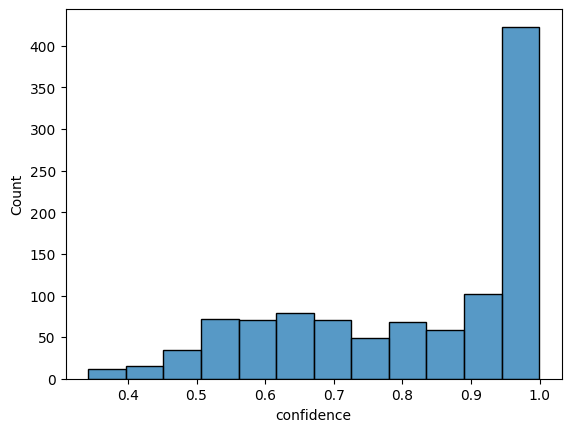

In [65]:
sns.histplot(new_clients.loc[new_clients['label_pred']=='Facilities', 'confidence'])

### Here we can actually see that super high confidence facilities predictions perform well, but it QUICKLY drops off at about confidence score <= .95

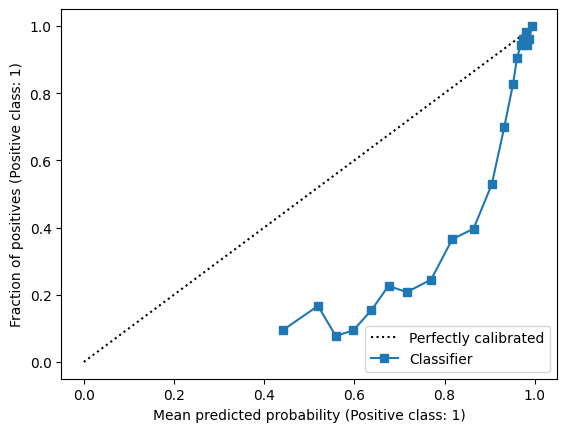

In [66]:
facilities = new_clients[new_clients.label_pred == 'Facilities']
disp = CalibrationDisplay.from_predictions(facilities['label'], facilities['confidence'], n_bins=20, strategy='quantile')

In [67]:
disp.__dict__

{'prob_true': array([0.09433962, 0.16666667, 0.07692308, 0.09433962, 0.15384615,
        0.22641509, 0.20754717, 0.24528302, 0.36538462, 0.39622642,
        0.52830189, 0.69811321, 0.82692308, 0.90566038, 0.94339623,
        0.96226415, 0.98076923, 0.94339623, 0.96226415, 1.        ]),
 'prob_pred': array([0.44112755, 0.51929098, 0.55892453, 0.59781319, 0.63776942,
        0.67574572, 0.71614559, 0.77028552, 0.81717206, 0.86421462,
        0.90467816, 0.93234718, 0.95184612, 0.9608992 , 0.968925  ,
        0.97486934, 0.98028941, 0.98359182, 0.98787987, 0.99389154]),
 'y_prob': 88       0.719483
 108      0.618243
 119      0.593987
 127      0.978580
 129      0.965213
            ...   
 12011    0.936174
 12012    0.996723
 12013    0.998619
 12015    0.997385
 12018    0.954986
 Name: confidence, Length: 1056, dtype: float64,
 'estimator_name': 'Classifier',
 'pos_label': 1,
 'line_': <matplotlib.lines.Line2D at 0x2a24143e8e0>,
 'ax_': <AxesSubplot:xlabel='Mean predicted probabilit

In [49]:
## set all predictions that were were in the facilities plus list to the lowest bucket
new_clients['confidence_facilities_plus'] = new_clients['confidence_score_bucket']
new_clients.loc[new_clients['facilities_plus']==1, 'confidence_facilities_plus'] = pd.Interval(0.0, .5, closed='right')

In [57]:
bucket_cumavg = new_clients.groupby('confidence_facilities_plus')[['confidence','label','row_cnt']].sum().sort_index(ascending=False).cumsum().reset_index()
bucket_cumavg['mean_confidence_score'] = bucket_cumavg['confidence']/bucket_cumavg['row_cnt']
bucket_cumavg['proportion_correct'] = bucket_cumavg['label']/bucket_cumavg['row_cnt']
bucket_cumavg['total'] = len(new_clients)
bucket_cumavg['row_pct_of_total'] = bucket_cumavg['row_cnt']/bucket_cumavg['total']

### Here all prediction labels in ['Facilities', 'Surgical Services', 'Post-Acute Care and Hospice', 'Talent/HR', 'Patient Care Unit'] have been moved to the bottom (0.0, 0.5] bucket

This does swing things a bit more, but complexity is even higher. May not be worth it.

In [58]:
bucket_cumavg[['confidence_facilities_plus', 'row_cnt','mean_confidence_score', 'proportion_correct', 'row_pct_of_total']]

,confidence_facilities_plus,row_cnt,mean_confidence_score,proportion_correct,row_pct_of_total
0,"(0.998, 1.0]",1368,0.998853,0.980263,0.112408
1,"(0.995, 0.998]",2067,0.998014,0.981132,0.169844
2,"(0.992, 0.995]",2585,0.997168,0.979884,0.212408
3,"(0.99, 0.992]",2989,0.996379,0.978923,0.245604
4,"(0.985, 0.99]",3548,0.994994,0.976607,0.291537
5,"(0.98, 0.985]",3948,0.993739,0.974164,0.324404
6,"(0.97, 0.98]",4604,0.991103,0.969374,0.378307
7,"(0.96, 0.97]",5035,0.988878,0.964647,0.413722
8,"(0.94, 0.96]",5647,0.984789,0.959447,0.464010
9,"(0.92, 0.94]",6082,0.980912,0.953140,0.499753


<AxesSubplot:xlabel='confidence', ylabel='Count'>

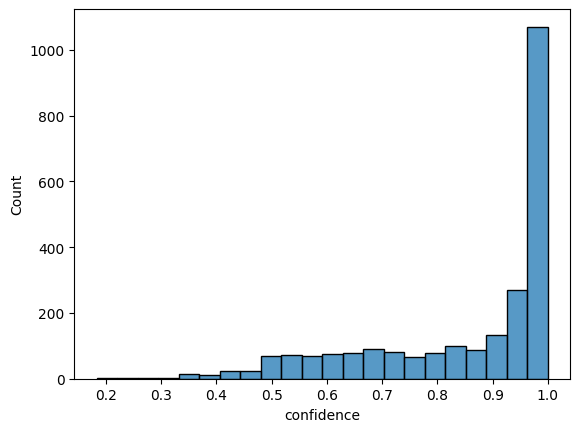

In [68]:
cols = ['Facilities', 'Surgical Services', 'Post-Acute Care and Hospice', 'Talent/HR', 'Patient Care Unit']
sns.histplot(new_clients.loc[new_clients['label_pred'].isin(cols), 'confidence'])

### Similar story here, but a higher proportion of these columns have super high confidence, and the drop off isn't as severe.

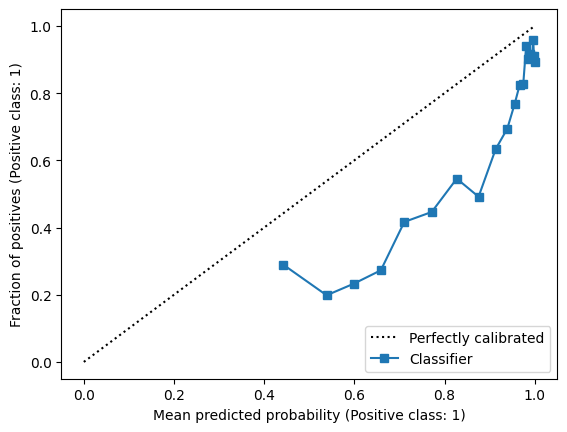

In [69]:
cols = ['Facilities', 'Surgical Services', 'Post-Acute Care and Hospice', 'Talent/HR', 'Patient Care Unit']
facilities_plus = new_clients[new_clients.label_pred.isin(cols)]
disp = CalibrationDisplay.from_predictions(facilities_plus['label'], facilities_plus['confidence'], n_bins=20, strategy='quantile')

In [70]:
disp.__dict__

{'prob_true': array([0.2892562 , 0.19834711, 0.23333333, 0.27272727, 0.41666667,
        0.44628099, 0.54545455, 0.49166667, 0.63333333, 0.69421488,
        0.76859504, 0.825     , 0.82644628, 0.94166667, 0.90082645,
        0.91666667, 0.90909091, 0.95833333, 0.90909091, 0.89256198]),
 'prob_pred': array([0.44248365, 0.53849829, 0.59953739, 0.6586839 , 0.71079315,
        0.77155537, 0.82705319, 0.87543561, 0.91337507, 0.93913471,
        0.95562147, 0.96670171, 0.9745142 , 0.98101118, 0.98570125,
        0.99055595, 0.99421889, 0.99666575, 0.99830103, 0.99957917]),
 'y_prob': 10       0.998399
 11       0.998888
 12       0.423722
 13       0.999484
 14       0.933132
            ...   
 12053    0.606244
 12079    0.682087
 12085    0.461196
 12152    0.799325
 12160    0.874647
 Name: confidence, Length: 2412, dtype: float64,
 'estimator_name': 'Classifier',
 'pos_label': 1,
 'line_': <matplotlib.lines.Line2D at 0x2a2414fe790>,
 'ax_': <AxesSubplot:xlabel='Mean predicted probabilit

# Given what we've seen, I personally don't know if it is worth it to add complexity beyond a simple confidence score cut, again I like the look of .9 (ie 90%), but there is no objectively right answer.